In [5]:
# -------------------------------
# Imports
# -------------------------------
import numpy as np
import pandas as pd
import optuna
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, roc_auc_score
import time
import gc
import warnings
warnings.filterwarnings('ignore')

# -------------------------------
# Load Data
# -------------------------------
X_train = pd.read_csv('../data/X_train_encoded.csv')
X_test  = pd.read_csv('../data/X_test_encoded.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test  = pd.read_csv('../data/y_test.csv')

# Map target to numeric
y_train_numeric = y_train['Target'].map({'Low': 0, 'Medium': 1, 'High': 2}).values
y_test_numeric  = y_test['Target'].map({'Low': 0, 'Medium': 1, 'High': 2}).values

num_classes = len(np.unique(y_train_numeric))
print(f"Number of classes: {num_classes}")


Number of classes: 3


In [6]:

# -------------------------------
# Optuna objective for Gradient Boosting
# -------------------------------
def objective(trial):

    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 15, 255),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 100),
        'l2_regularization': trial.suggest_float('l2_regularization', 1e-6, 10.0, log=True),
        'max_iter': trial.suggest_int('max_iter', 200, 2000),
        'early_stopping': True,
        'validation_fraction': 0.1,
        'n_iter_no_change': 50,
        'random_state': 2026
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    logloss_scores = []

    for fold, (train_idx, valid_idx) in enumerate(
        skf.split(X_train, y_train_numeric)
    ):

        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train_numeric[train_idx], y_train_numeric[valid_idx]

        model = HistGradientBoostingClassifier(
            loss='log_loss',
            **params
        )

        model.fit(X_tr, y_tr)

        pred_val = model.predict_proba(X_val)
        fold_logloss = log_loss(y_val, pred_val)

        logloss_scores.append(fold_logloss)

        # ---- Optuna pruning (fold-based) ----
        trial.report(fold_logloss, step=fold)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return np.mean(logloss_scores)


In [7]:

# -------------------------------
# Optuna study
# -------------------------------
debug = True
timeout = 60 if debug else 3600

start = time.time()

sampler = optuna.samplers.TPESampler(
    n_startup_trials=30,
    multivariate=True
)

pruner = optuna.pruners.SuccessiveHalvingPruner(
    min_resource=2,
    reduction_factor=4,
    min_early_stopping_rate=1
)

study = optuna.create_study(
    direction='minimize',
    sampler=sampler,
    pruner=pruner
)

study.optimize(objective, n_trials=30, timeout=timeout)

end = time.time()

print(f"Optuna finished in {end - start:.2f} seconds")
print("Best params:", study.best_params)
print("Best CV multi_logloss:", study.best_value)

# -------------------------------
# Train final Gradient Boosting model
# -------------------------------
best_params = study.best_params
best_params.update({
    'early_stopping': True,
    'validation_fraction': 0.1,
    'n_iter_no_change': 50,
    'random_state': 2026
})

print("\nTraining final Gradient Boosting model on full training data...")
final_model = HistGradientBoostingClassifier(
    loss='log_loss',
    **best_params
)

final_model.fit(X_train, y_train_numeric)

# -------------------------------
# Evaluate on test set
# -------------------------------
pred_test = final_model.predict_proba(X_test)

roc_auc = roc_auc_score(
    y_test_numeric,
    pred_test,
    multi_class='ovr',
    average='weighted'
)

logloss = log_loss(y_test_numeric, pred_test)
accuracy = np.mean(np.argmax(pred_test, axis=1) == y_test_numeric)

print("\n--- Test set performance ---")
print(f"ROC AUC (OVR weighted): {roc_auc:.5f}")
print(f"Log Loss:           {logloss:.5f}")
print(f"Accuracy:           {accuracy:.5f}")

gc.collect()



[I 2026-01-02 21:53:07,802] A new study created in memory with name: no-name-7c0221da-d838-4924-b5f4-737f30b75c4e
[I 2026-01-02 21:53:34,026] Trial 0 finished with value: 0.39362311652737253 and parameters: {'learning_rate': 0.11294060971011531, 'max_depth': 15, 'max_leaf_nodes': 123, 'min_samples_leaf': 36, 'l2_regularization': 2.6959886304289323e-05, 'max_iter': 1757}. Best is trial 0 with value: 0.39362311652737253.
[I 2026-01-02 21:54:13,058] Trial 1 finished with value: 0.3178037009103839 and parameters: {'learning_rate': 0.005917855545993431, 'max_depth': 7, 'max_leaf_nodes': 72, 'min_samples_leaf': 70, 'l2_regularization': 3.7531842820198476e-05, 'max_iter': 1400}. Best is trial 1 with value: 0.3178037009103839.


Optuna finished in 65.26 seconds
Best params: {'learning_rate': 0.005917855545993431, 'max_depth': 7, 'max_leaf_nodes': 72, 'min_samples_leaf': 70, 'l2_regularization': 3.7531842820198476e-05, 'max_iter': 1400}
Best CV multi_logloss: 0.3178037009103839

Training final Gradient Boosting model on full training data...

--- Test set performance ---
ROC AUC (OVR weighted): 0.94115
Log Loss:           0.31697
Accuracy:           0.88098


29

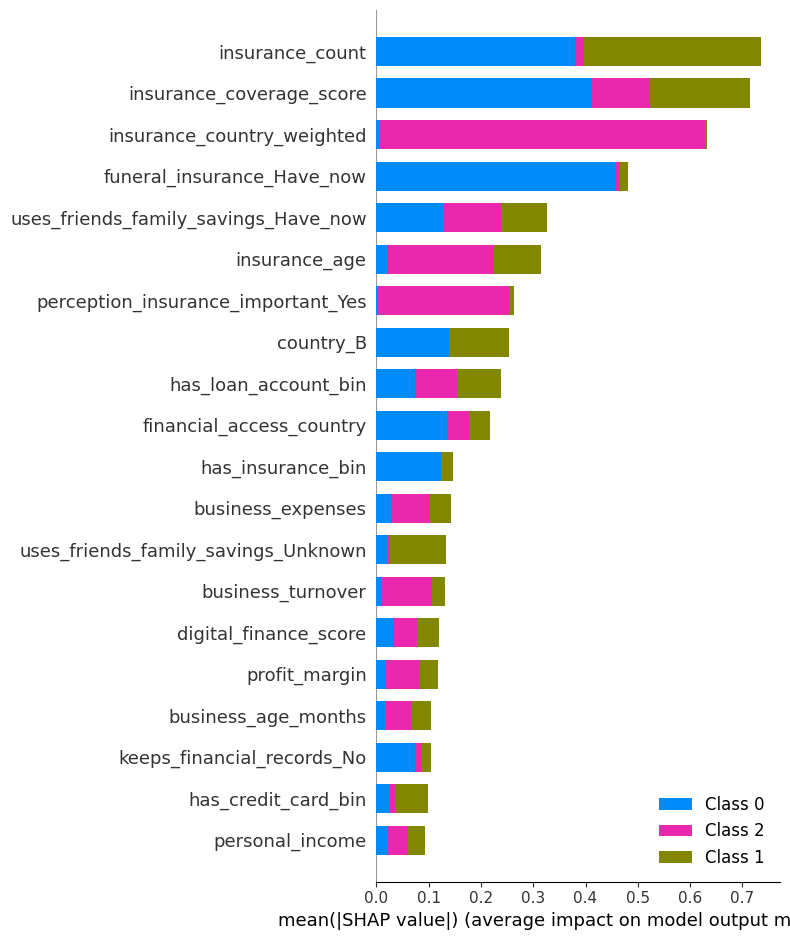

In [ ]:
import shap
import numpy as np
X_shap = X_train.sample(1000, random_state=42)  # reduce if slow
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_shap)
shap.summary_plot(
    shap_values,
    X_shap,
    plot_type="bar",
    class_names=[f"Class {i}" for i in range(len(shap_values))]
)

In [10]:
# -------------------------------
# Optuna objective for ExtraTrees
# -------------------------------
from sklearn.ensemble import ExtraTreesClassifier


def objective(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 2000),
        'max_depth': trial.suggest_int('max_depth', 5, 40),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 30),
        'max_features': trial.suggest_float('max_features', 0.3, 1.0),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'class_weight': trial.suggest_categorical(
            'class_weight', [None, 'balanced', 'balanced_subsample']
        ),
        'n_jobs': -1,
        'random_state': 2026
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    logloss_scores = []

    for fold, (train_idx, valid_idx) in enumerate(
        skf.split(X_train, y_train_numeric)
    ):

        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train_numeric[train_idx], y_train_numeric[valid_idx]

        model = ExtraTreesClassifier(**params)
        model.fit(X_tr, y_tr)

        pred_val = model.predict_proba(X_val)
        fold_logloss = log_loss(y_val, pred_val)
        logloss_scores.append(fold_logloss)

        # ---- Optuna pruning (fold-based) ----
        trial.report(fold_logloss, step=fold)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return np.mean(logloss_scores)

# -------------------------------
# Optuna study
# -------------------------------
debug = True
timeout = 60 if debug else 3600

start = time.time()

sampler = optuna.samplers.TPESampler(
    n_startup_trials=30,
    multivariate=True
)

pruner = optuna.pruners.SuccessiveHalvingPruner(
    min_resource=2,
    reduction_factor=4,
    min_early_stopping_rate=1
)

study = optuna.create_study(
    direction='minimize',
    sampler=sampler,
    pruner=pruner
)

study.optimize(objective, n_trials=30, timeout=timeout)

end = time.time()

print(f"Optuna finished in {end - start:.2f} seconds")
print("Best params:", study.best_params)
print("Best CV multi_logloss:", study.best_value)

# -------------------------------
# Train final ExtraTrees model
# -------------------------------
best_params = study.best_params
best_params.update({
    'n_jobs': -1,
    'random_state': 2026
})

print("\nTraining final ExtraTrees model on full training data...")
final_model = ExtraTreesClassifier(**best_params)
final_model.fit(X_train, y_train_numeric)

# -------------------------------
# Evaluate on test set
# -------------------------------
pred_test = final_model.predict_proba(X_test)

roc_auc = roc_auc_score(
    y_test_numeric,
    pred_test,
    multi_class='ovr',
    average='weighted'
)

logloss = log_loss(y_test_numeric, pred_test)
accuracy = np.mean(np.argmax(pred_test, axis=1) == y_test_numeric)

print("\n--- Test set performance ---")
print(f"ROC AUC (OVR weighted): {roc_auc:.5f}")
print(f"Log Loss:           {logloss:.5f}")
print(f"Accuracy:           {accuracy:.5f}")

gc.collect()


[I 2026-01-02 22:17:59,473] A new study created in memory with name: no-name-a2d6905b-2986-4b10-9a99-df193abe9b5a
[I 2026-01-02 22:18:22,465] Trial 0 finished with value: 0.36152894780479594 and parameters: {'n_estimators': 1145, 'max_depth': 32, 'min_samples_split': 13, 'min_samples_leaf': 11, 'max_features': 0.5038862533010751, 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.36152894780479594.
[I 2026-01-02 22:18:38,229] Trial 1 finished with value: 0.30182502733457106 and parameters: {'n_estimators': 968, 'max_depth': 11, 'min_samples_split': 16, 'min_samples_leaf': 6, 'max_features': 0.8950948510681496, 'bootstrap': True, 'class_weight': None}. Best is trial 1 with value: 0.30182502733457106.
[I 2026-01-02 22:18:44,536] Trial 2 finished with value: 0.3953839346211532 and parameters: {'n_estimators': 500, 'max_depth': 11, 'min_samples_split': 27, 'min_samples_leaf': 27, 'max_features': 0.34520498956991547, 'bootstrap': True, 'class_weight': 'balanced'}

Optuna finished in 91.51 seconds
Best params: {'n_estimators': 968, 'max_depth': 11, 'min_samples_split': 16, 'min_samples_leaf': 6, 'max_features': 0.8950948510681496, 'bootstrap': True, 'class_weight': None}
Best CV multi_logloss: 0.30182502733457106

Training final ExtraTrees model on full training data...

--- Test set performance ---
ROC AUC (OVR weighted): 0.94464
Log Loss:           0.31056
Accuracy:           0.87734


116

In [11]:
import optuna.visualization as vis



# Slice plot for individual params
vis.plot_slice(study)
